Blood Group Detection from Fingerprint using VGG16

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the required libraries

In [2]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
import zipfile
import warnings
warnings.filterwarnings('ignore')

Download and unzip the dataset

In [3]:
!kaggle datasets download -d rajumavinmar/finger-print-based-blood-group-dataset

Dataset URL: https://www.kaggle.com/datasets/rajumavinmar/finger-print-based-blood-group-dataset
License(s): unknown
finger-print-based-blood-group-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
zip_ref = zipfile.ZipFile('/content/finger-print-based-blood-group-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

Data preprocessing

In [5]:
file_path = '/content/dataset_blood_group'

In [6]:
data = pd.DataFrame({
    'Filepath': glob.glob(file_path + "/*/*"),
    'Label': [os.path.basename(os.path.dirname(fp)) for fp in glob.glob(file_path + "/*/*")]
})

Splitting the dataset into train and test sets

In [7]:
train, test = train_test_split(data, test_size=0.20, random_state=42, stratify=data["Label"])

Image data augmentation

In [8]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4800 validated image filenames belonging to 8 classes.
Found 1200 validated image filenames belonging to 8 classes.


Model architecture

In [9]:
pretrained_model = DenseNet121(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)

pretrained_model.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
inputs = pretrained_model.input
x = tf.keras.layers.Flatten()(pretrained_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(8, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 23,848,904 (90.98 MB)

 Trainable params: 16,811,400 (64.13 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Model training

In [11]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20
)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 70s 276ms/step - accuracy: 0.5540 - loss: 5.1281 - val_accuracy: 0.7867 - val_loss: 1.0095
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 44s 129ms/step - accuracy: 0.8334 - loss: 0.6712 - val_accuracy: 0.7867 - val_loss: 0.9507
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.8966 - loss: 0.3082 - val_accuracy: 0.8158 - val_loss: 0.9030
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.9209 - loss: 0.2463 - val_accuracy: 0.8517 - val_loss: 0.5337
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - accuracy: 0.9540 - loss: 0.1321 - val_accuracy: 0.8625 - val_loss: 0.5549
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.9727 - loss: 0.0770 - val_accuracy: 0.8658 - val_loss: 0.5587
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.9690 - loss: 0.0801 - val_accuracy: 0.8383 - val_loss: 0.7054
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.9452 - loss: 0

Saving the model

In [12]:
model.save("densenet121.keras")

Model evaluation

In [13]:
name_class = sorted(os.listdir(file_path))
pred = model.predict(valid_gen)
pred_labels = np.argmax(pred, axis=1)
true_labels = valid_gen.classes

print(classification_report(true_labels, pred_labels, target_names=name_class))

38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 405ms/step
              precision    recall  f1-score   support

          A+       0.95      0.87      0.91       113
          A-       0.82      0.87      0.84       202
         AB+       0.90      0.82      0.86       142
         AB-       0.79      0.92      0.85       152
          B+       0.93      0.74      0.82       130
          B-       0.95      0.85      0.90       148
          O+       0.83      0.87      0.85       171
          O-       0.81      0.92      0.86       142

    accuracy                           0.86      1200
   macro avg       0.87      0.86      0.86      1200
weighted avg       0.87      0.86      0.86      1200



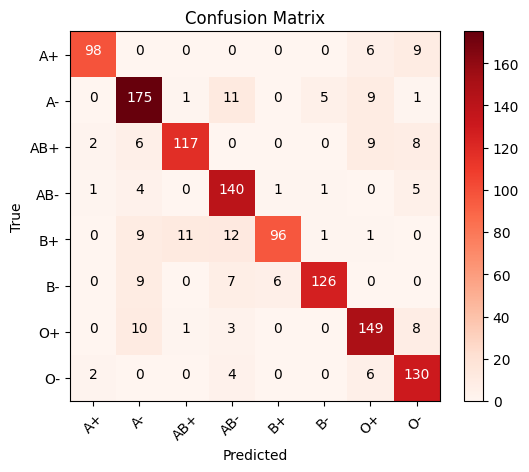

In [14]:
cm = confusion_matrix(true_labels, pred_labels)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(name_class))
plt.xticks(tick_marks, name_class, rotation=45)
plt.yticks(tick_marks, name_class)

for i in range(len(name_class)):
    for j in range(len(name_class)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Visualizing accuracy and loss over epochs

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

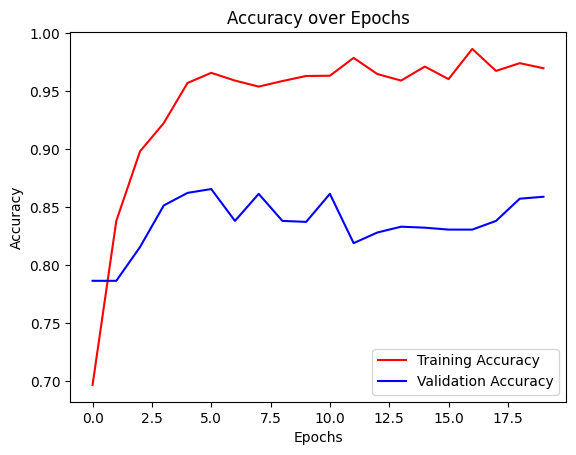

In [16]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

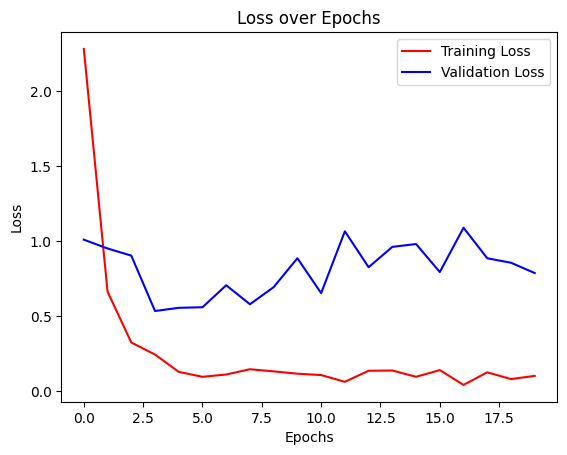

In [17]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Model prediction

In [18]:
class_names = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']

def predict_blood_group(image_path, model, class_names):
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    confidence_score = np.max(predictions) * 100

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence_score:.2f}%", fontsize=14, color='black')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


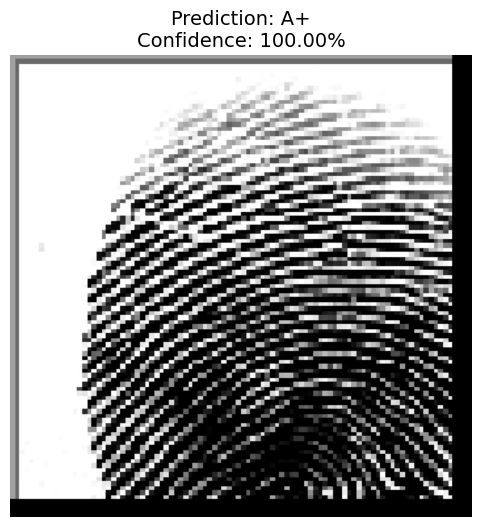

In [19]:
image_path = '/content/dataset_blood_group/A+/cluster_0_1001.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


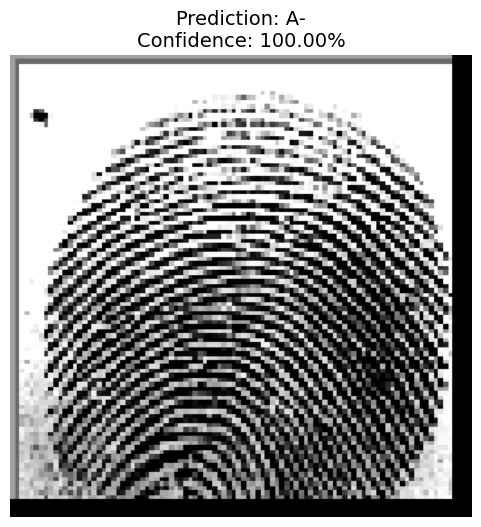

In [20]:
image_path = '/content/dataset_blood_group/A-/cluster_1_1007.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


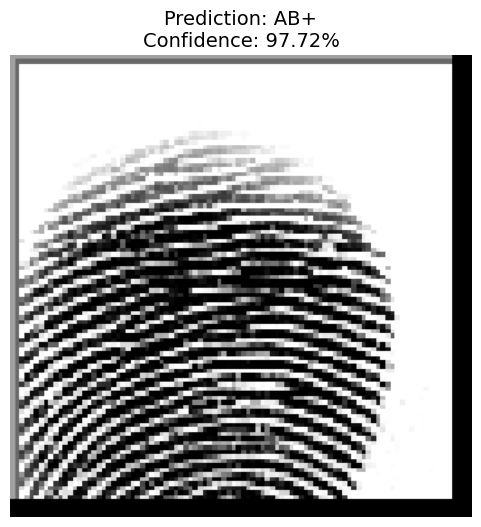

In [21]:
image_path = '/content/dataset_blood_group/AB+/cluster_4_100.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


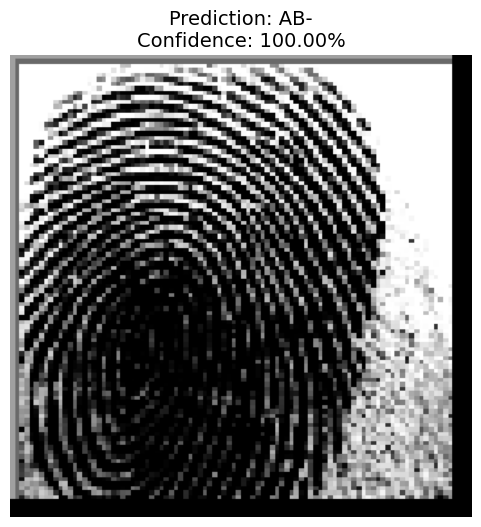

In [22]:
image_path = '/content/dataset_blood_group/AB-/cluster_5_1013.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


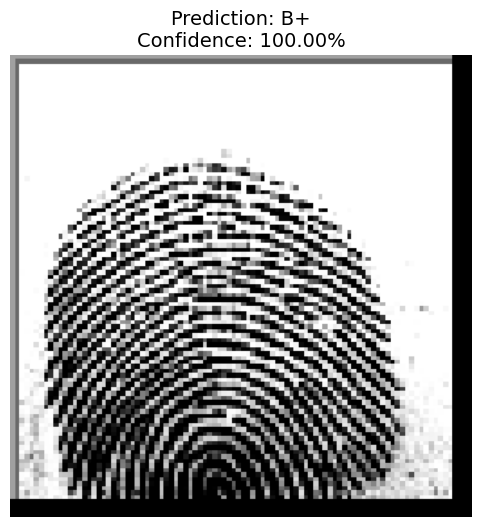

In [23]:
image_path = '/content/dataset_blood_group/B+/cluster_2_1077.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


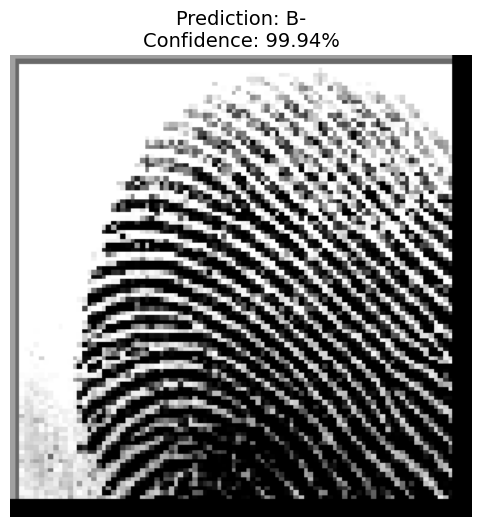

In [24]:
image_path = '/content/dataset_blood_group/B-/cluster_3_1018.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


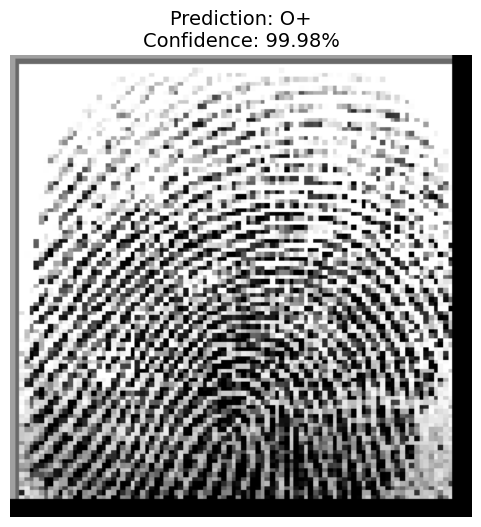

In [25]:
image_path = '/content/dataset_blood_group/O+/cluster_6_1004.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


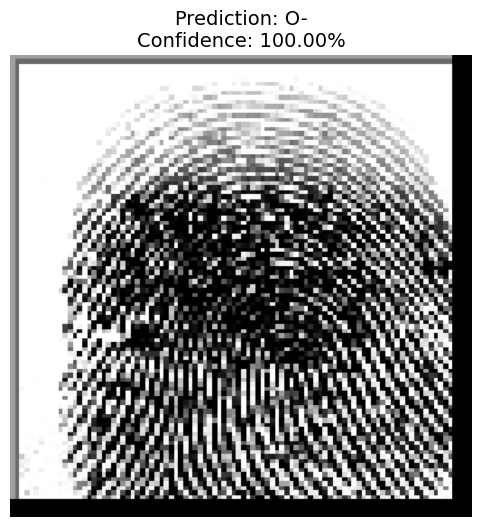

In [26]:
image_path = '/content/dataset_blood_group/O-/cluster_7_1028.BMP'
predict_blood_group(image_path, model, class_names)